In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
from scipy.linalg import sqrtm
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

Load the points from both datasets.

In [2]:
circle = pd.read_csv('Circle.csv', header=None, names=['x', 'y'])
spiral = pd.read_csv('Spiral.csv', header=None, names=['x', 'y', 'label'])
circle.head(), spiral.head()

(        x        y
 0  2.7147  0.81472
 1  2.8054  0.94572
 2  2.0253  0.20682
 3  2.8096  1.03310
 4  2.5257  0.79188,
        x     y  label
 0  31.95  7.95      3
 1  31.15  7.30      3
 2  30.45  6.65      3
 3  29.70  6.00      3
 4  28.90  5.55      3)

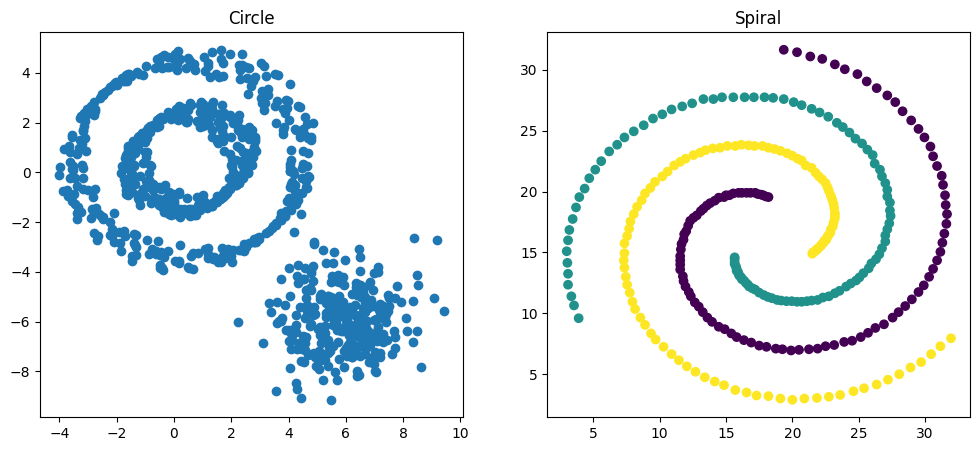

In [3]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(circle['x'],circle['y'])
ax[0].set_title('Circle')
ax[1].scatter(spiral['x'],spiral['y'],c=spiral['label'])
ax[1].set_title('Spiral')
plt.show()

In [4]:
circle_points = circle[['x', 'y']].values
spiral_points = spiral[['x', 'y']].values

Define the similarity function:

$$
s_{i,j} = \exp\left(-\frac{\|X_i - X_j\|^2}{2\sigma^2}\right)
$$



In [5]:
def create_similarity_matrix(X, sigma): 
    n_points = X.shape[0]
    similarity_matrix = np.zeros((n_points, n_points))

    for i in range(n_points):
        for j in range(n_points):
            similarity_matrix[i, j] = np.exp(-(np.linalg.norm(X[i] - X[j]))**2 / (2 * sigma**2))

    return similarity_matrix


Given a set of data points X and the similarity function, construct the k-nearest neighborhood similarity graph and its adjacency
matrix W. 

In [6]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors

def create_adjacency_matrix(X, k, sigma=1):        
    similarity_matrix = create_similarity_matrix(X, sigma)
    np.fill_diagonal(similarity_matrix, 0)  # diagonal elements are zero by definition
    # keep only the k highest values for each row/columns in the similarity matrix
    n_points = similarity_matrix.shape[0]
    W = np.zeros_like(similarity_matrix)

    for i in range(n_points):
        row = similarity_matrix[i]
        top_k_indices = np.argsort(row)[-k:]
        W[i, top_k_indices] = row[top_k_indices]

    W = np.maximum(W,W.T) # so that W is symmetric
    return W
 

In [7]:
W = create_adjacency_matrix(circle_points, 10)

Construct the degree matrix D and the Laplacian matrix L = D −W. We apply also the same process to the normalized symmetric Laplacian matrix $L_{\text{sym}} \in \mathbb{R}^{N \times N}$ that is defined as

$$
L_{\text{sym}} := D^{-\frac{1}{2}} L D^{-\frac{1}{2}} = I - D^{-\frac{1}{2}} W D^{-\frac{1}{2}}
$$ 

In [8]:
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])    

In [9]:
W = csr_matrix(W)
D = csr_matrix(D)

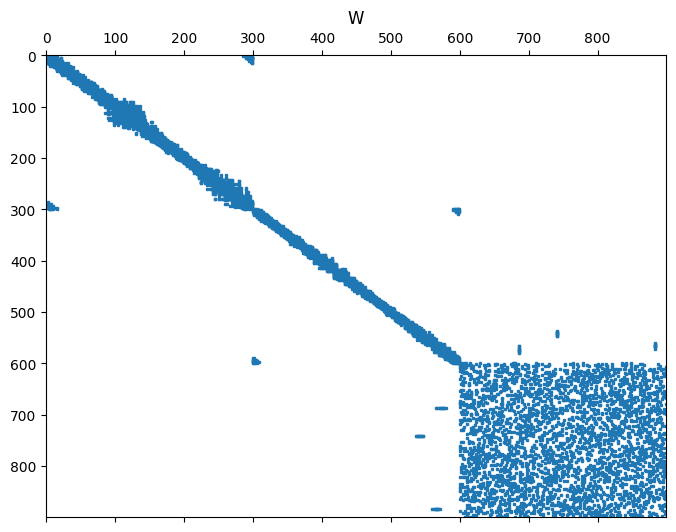

In [10]:
plt.figure(figsize=(8, 6))
plt.spy(W, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("W")
plt.show()

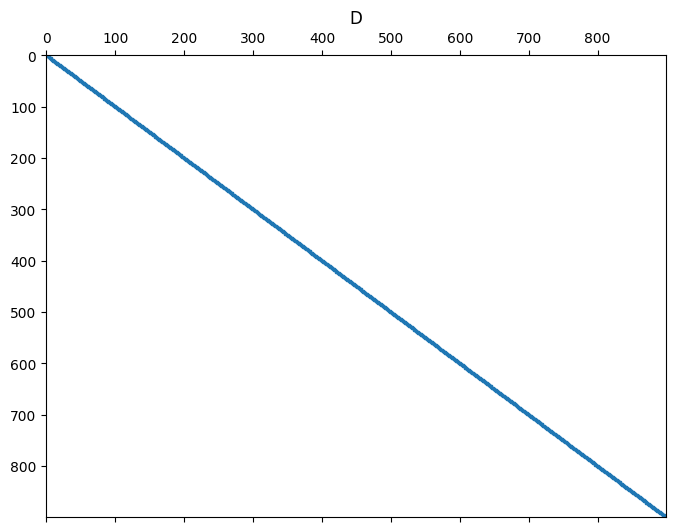

In [11]:
plt.figure(figsize=(8, 6))
plt.spy(D, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("D")
plt.show()

In [12]:
L = D - W
L_sym = D.power(-0.5).dot(L).dot(D.power(-0.5))

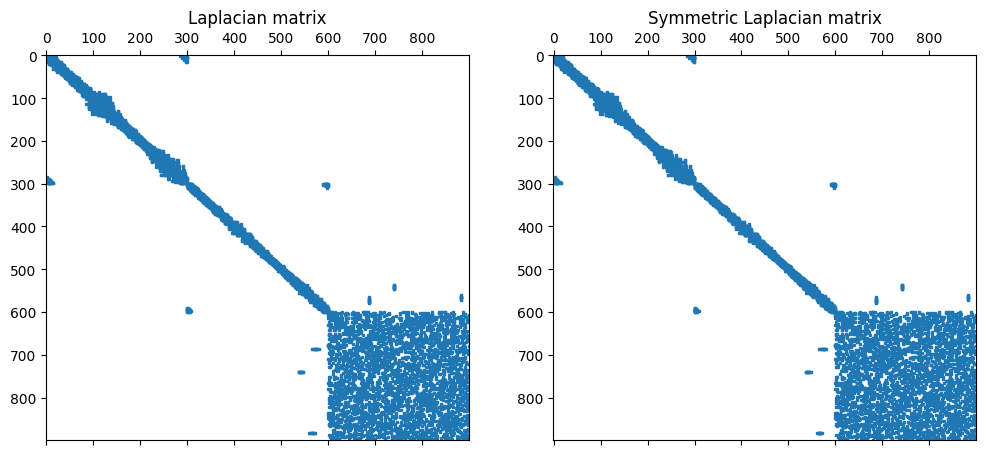

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].spy(L, markersize=2, aspect='auto')
ax[0].set_title('Laplacian matrix')
ax[1].spy(L_sym, markersize=2, aspect='auto')
ax[1].set_title('Symmetric Laplacian matrix')
plt.show()

Compute the number of connected components of the similarity graph. The number of connected components correspond to the nummber of 0 eigenvalues of the Laplacian matrix L.

In [14]:
eigenvalues, eigenvectors = eigsh(L, k=15, which='SM')
eigenvalues_sym, eigenvectors_sym = eigsh(L_sym, k=15, which='SM')

In [15]:
num_connected_components = np.sum(np.isclose(eigenvalues, 0, atol=1e-8))
print("Number of connected components:", num_connected_components)

Number of connected components: 2


We can define the *Inverse Power Method* to compute eigenvalues and eigenvectors.


In [22]:
def inverse_power_method(A, v0, maxIter=1000, relTol=1e-8, p=0):
    v0 = v0 / np.linalg.norm(v0,2)
    l0 = p
    k = 0
    while True:
        v1 = np.linalg.solve(A - p * np.eye(A.shape[0]), v0)
        mu = np.dot(v1, v0)
        v1 = v1 / np.linalg.norm(v1,2)
        k += 1
        if(k>maxIter or np.abs(mu-l0)<relTol*(np.abs(mu))):
            break

        v0 = v1
        l0 = mu
    return mu, v1


In [36]:
def deflation_method(A, k):
    eigenvalues = []
    eigenvectors = []

    A_current = A.copy()

    for i in range(k):
        lambda_i, v_i = inverse_power_method(A_current, np.random.rand(A.shape[0]), maxIter=1000, relTol=1e-8)
        lambda_i = 1/lambda_i
        eigenvalues.append(lambda_i)
        eigenvectors.append(v_i)
        A_current = A_current - np.outer(v_i, v_i)

    return eigenvalues, eigenvectors

In [37]:
eigenvalues,_ = deflation_method(L, 15)

In [38]:
print(sorted(eigenvalues))  

[np.float64(2.3684757859507984e-17), np.float64(1.0510111299762166e-16), np.float64(0.0048216047070620575), np.float64(0.02858559963394849), np.float64(0.04247439524641237), np.float64(0.0428866205808739), np.float64(0.08055483735827851), np.float64(0.12636684053280064), np.float64(0.13492477322636176), np.float64(0.209032857339919), np.float64(0.21725041719176125), np.float64(0.22081472220178744), np.float64(0.2526501811171585), np.float64(0.2814193731972656), np.float64(0.2938457059887882)]


In [26]:
print(sorted(np.abs(eigenvalues)))

[np.float64(2.4051459400819205e-16), np.float64(1.1104589583809834e-15), np.float64(0.004821604706615751), np.float64(0.028585599412787013), np.float64(0.042474373890026305), np.float64(0.04288664178924435), np.float64(0.08055483692434227), np.float64(0.1263668327362886), np.float64(0.13492477994741178), np.float64(0.2090328329824195), np.float64(0.21725037633843147), np.float64(0.22081477969505287), np.float64(0.2526501764717678), np.float64(0.2814193521328868), np.float64(0.293845733076165)]


Compute some small eigenvalues of L and use their values to choose a
suitable number of clusters M for the points data-sets.

<module 'matplotlib.pyplot' from 'c:\\Algebra_labs\\myenv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

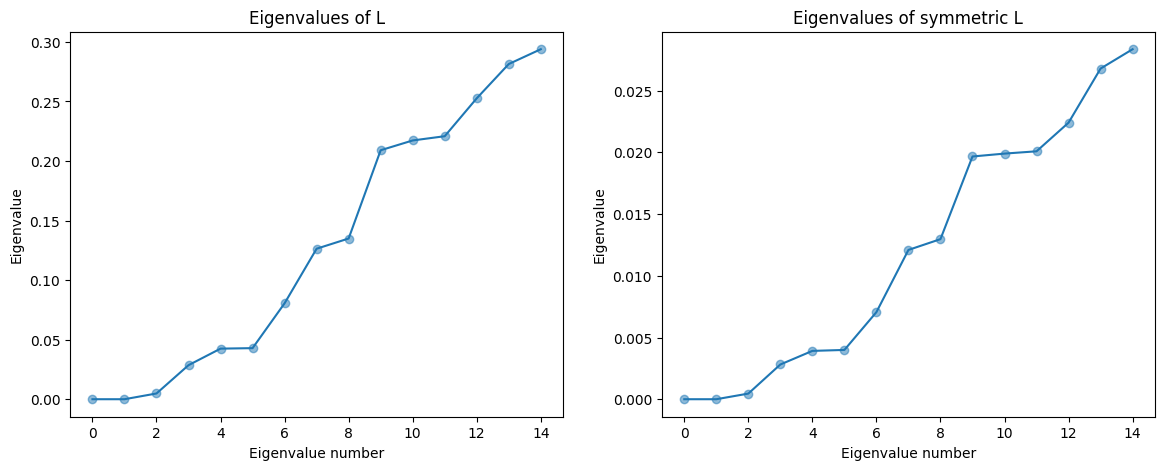

In [39]:
#plot on x axis the # of the eigenvalue and on y axis the value of the eigenvalue
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues))
ax[0].scatter(np.arange(0,15,step=1), np.sort(eigenvalues), alpha=0.5)
ax[0].set_title('Eigenvalues of L')
ax[0].set_xlabel("Eigenvalue number")
ax[0].set_ylabel("Eigenvalue")
ax[1].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues_sym))
ax[1].scatter(np.arange(0,15,step=1), np.sort(eigenvalues_sym), alpha=0.5)
ax[1].set_title('Eigenvalues of symmetric L')
ax[1].set_xlabel("Eigenvalue number")
ax[1].set_ylabel("Eigenvalue")
plt


Compute the $M$ eigenvectors $u_1, u_2, \dots, u_M \in \mathbb{R}^N$ that correspond to the $M$ smallest eigenvalues of the Laplacian matrix. Define the matrix $U \in \mathbb{R}^{N \times M}$ with these eigenvectors as columns. We try with M=2 and M=3.
For $i = 1, \dots, N$, let $\mathbf{y}_i \in \mathbb{R}^M$ be the vector corresponding to the $i$-th row of $U$. Cluster the points $\mathbf{y}_i$, $i = 1, \dots, N$ in $\mathbb{R}^M$ with the $k$-means algorithm into clusters $C_1, \dots, C_M$.

In [17]:
def show_clustering(df, column_name):
    plt.figure(figsize=(5, 4))  
    plt.scatter(df['x'], df['y'], c=df[column_name])
    plt.title("Spectral clustering")
    plt.show()

In [ ]:
M = [2,3]
for m in M:
    U = eigenvectors[:, 0:m] 
    km = KMeans(n_clusters=m)
    km.fit(U)
    circle['cluster'] = km.labels_ 
    print(f"The silhouette score of the clustering with M = {m} is {silhouette_score(circle_points, circle['cluster'])}")
    show_clustering(circle, "cluster")

In [ ]:
for m in M:
    U_sym = eigenvectors_sym[:, 0:m] 
    km = KMeans(n_clusters=m)
    km.fit(U_sym)
    circle['cluster_sym'] = km.labels_ 
    print(f"The silhouette score of the clustering with M = {m} is {silhouette_score(circle_points, circle['cluster_sym'])}")
    show_clustering(circle, "cluster_sym")

Do same steps for spiral dataset.

In [20]:
W = create_adjacency_matrix(spiral_points, 10)

In [21]:
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])    

In [22]:
W = csr_matrix(W)
D = csr_matrix(D)

In [ ]:
plt.figure(figsize=(8, 6))
plt.spy(W, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("W")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.spy(D, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("D")
plt.show()

In [25]:
L = D - W
L_sym = D.power(-0.5).dot(L).dot(D.power(-0.5))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].spy(L, markersize=2, aspect='auto')
ax[0].set_title('Laplacian matrix')
ax[1].spy(L_sym, markersize=2, aspect='auto')
ax[1].set_title('Symmetric Laplacian matrix')
plt.show()

In [27]:
eigenvalues, eigenvectors = eigsh(L, k=15, which='SM')
eigenvalues_sym, eigenvectors_sym = eigsh(L_sym, k=15, which='SM')

In [ ]:
#plot on x axis the # of the eigenvalue and on y axis the value of the eigenvalue
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues))
ax[0].scatter(np.arange(0,15,step=1), np.sort(eigenvalues), alpha=0.5)
ax[0].set_title('Eigenvalues of L')
ax[0].set_xlabel("Eigenvalue number")
ax[0].set_ylabel("Eigenvalue")
ax[1].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues_sym))
ax[1].scatter(np.arange(0,15,step=1), np.sort(eigenvalues_sym), alpha=0.5)
ax[1].set_title('Eigenvalues of symmetric L')
ax[1].set_xlabel("Eigenvalue number")
ax[1].set_ylabel("Eigenvalue")
plt.show()

In [ ]:
M = [3,4]
for m in M:
    U = eigenvectors[:, 0:m] 
    km = KMeans(n_clusters=m)
    km.fit(U)
    spiral['cluster'] = km.labels_ 
    print(f"The silhouette score of the clustering with M = {m} is {silhouette_score(spiral_points, spiral['cluster'])}")
    show_clustering(spiral, "cluster")

In [ ]:
for m in M:
    U_sym = eigenvectors_sym[:, 0:m] 
    km = KMeans(n_clusters=m)
    km.fit(U_sym)
    spiral['cluster_sym'] = km.labels_ 
    print(f"The silhouette score of the clustering with M = {m} is {silhouette_score(spiral_points, spiral['cluster_sym'])}")
    show_clustering(spiral, "cluster_sym")

Compute the clusters for the same set of points with other clustering
methods (k-means,...) and compare the results.

In [ ]:
km = KMeans(n_clusters=3)
km.fit(circle_points)

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(circle['x'], circle['y'], c=km.labels_)
plt.title("K-means clustering")

In [ ]:
km = KMeans(n_clusters=3)
km.fit(spiral_points)

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(spiral['x'], spiral['y'], c=km.labels_)
plt.title("K-means clustering")

In [ ]:
cls = DBSCAN()
cls.fit(circle_points)

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(circle['x'], circle['y'], c=cls.labels_)
plt.title("DBSCAN clustering")

In [ ]:
cls.fit(spiral_points)

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(spiral['x'], spiral['y'], c=cls.labels_)
plt.title("DBSCAN clustering")